In [2]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DIR_WORKSPACE = '/node200data/18parkky/datasets'

In [5]:
# Prepare iCMS marker genes from Joanito et al. (https://doi.org/10.1038/s41588-022-01100-4, Supplementary Table 14) 
iCMS_marker_genes = pd.read_csv(f'{DIR_WORKSPACE}/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv', )

iCMS3_up = list(iCMS_marker_genes['iCMS3_Up'].dropna())
iCMS3_dw = list(iCMS_marker_genes['iCMS3_Down'].dropna())
iCMS2_up = list(iCMS_marker_genes['iCMS2_Up'].dropna())
iCMS2_dw = list(iCMS_marker_genes['iCMS2_Down'].dropna())

## Chen et al

In [6]:
chen_metadata = pd.read_csv(f'{DIR_WORKSPACE}/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.CRC.woSD.run_meta.organized.tsv', sep='\t',)
chen_metadata.head(1)

Accession SampleID PatientID TreatmentStage TreatmentPoint BiopsySite  \
0  HRR1372976  P04-N-I       P04            Pre       Baseline     Normal   

    MMR  MSI  TMB Response LibraryType    TumorLocation CancerType  
0  dMMR  MSI  487       CR   scRNA-seq  Ascending colon        CRC

In [7]:
adata = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.h5ad')
adata = adata.raw.to_adata() # Revert to raw because we're going to re-cluster epithelial cells

In [ ]:
chen_patient_metadata = pd.read_csv(f'{DIR_WORKSPACE}/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
dict_PatientID_to_TumorLoc   = { list(tup)[1] : list(tup)[5] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorLoc['P15'] = 'Sigmoid colon'
dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_CancerType = { list(tup)[1] : list(tup)[4] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata.obs['TumorLocation'] = [ dict_PatientID_to_TumorLoc[PID] for PID in adata.obs['PatientID'] ]
adata.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata.obs['PatientID'] ]
adata.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata.obs['PatientID'] ]
adata.obs['CancerType'] = [ dict_PatientID_to_CancerType[PID] for PID in adata.obs['PatientID'] ]
adata.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata.obs['PatientID'] ]

In [ ]:
adata.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata.obs['PatientID'] ]
adata.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata.obs['PatientID'] ]
adata.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata.obs['PatientID'] ]

In [8]:
adata.obs['MSI_score'] = adata.obs['AvgSTRDiff'] * adata.obs['StdSTRDiff'] * -1

In [9]:
# Create dictionary to map MSI status and ICI response for each patient in the Anndata
dict_SampleID_to_MSIstatus  = { SampleID : edf.iloc[0].MSI for SampleID, edf in chen_metadata.groupby("SampleID") }
dict_SampleID_to_Response   = { SampleID : edf.iloc[0].Response for SampleID, edf in chen_metadata.groupby("SampleID") }

adata.obs['MSI']        = [ dict_SampleID_to_MSIstatus[SID] for SID in adata.obs['SampleID'] ]
adata.obs['Response']   = [ dict_SampleID_to_Response[SID] for SID in adata.obs['SampleID'] ]

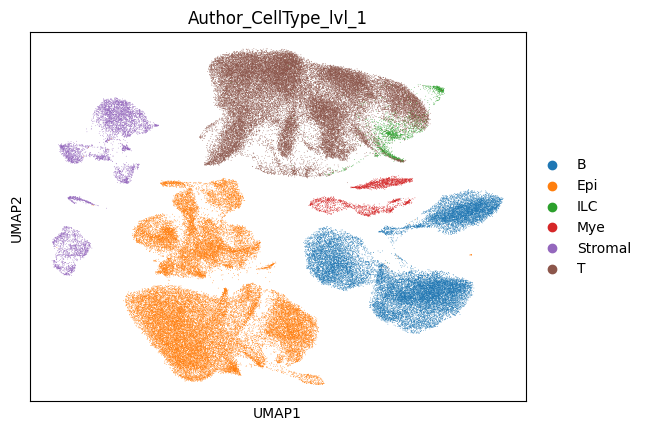

In [8]:
sc.pl.umap(adata, color=['Author_CellType_lvl_1',])

### Epithelial subclustering - Distinguishing Tumor vs. Normal epithelial

In [10]:
adata_epi = adata[(adata.obs['Author_CellType_lvl_1']=='Epi')].copy()

In [11]:
adata_epi.raw = adata_epi.copy()
sc.pp.normalize_total(adata_epi)
sc.pp.log1p(adata_epi)
sc.pp.highly_variable_genes(adata_epi, n_top_genes=2000, batch_key="SampleID")
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


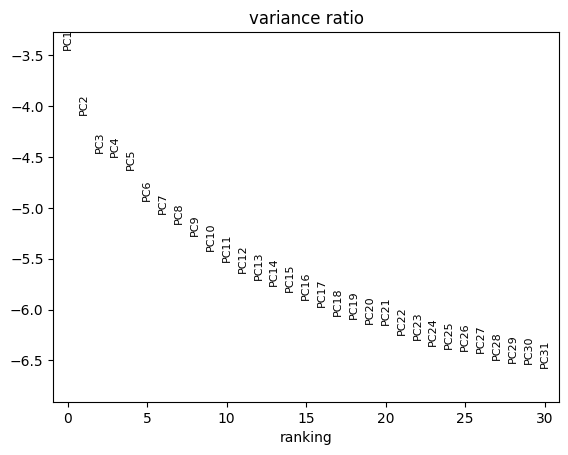

In [12]:
sc.pp.scale(adata_epi, max_value=10)
sc.tl.pca(adata_epi, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi, log=True)

In [13]:
sc.pp.neighbors(adata_epi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi,)

2025-03-04 14:06:51.774017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 14:06:51.775304: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 14:06:51.779933: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 14:06:51.795463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 14:06:51.820024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [14]:
sc.tl.leiden(adata_epi, resolution=0.2)

/tmp/ipykernel_41323/2576127689.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_epi, resolution=0.2)


In [15]:
sc.tl.rank_genes_groups(adata_epi, groupby='leiden', use_raw=False,)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value enco

In [16]:
# Inspect patient-composition of each leiden cluster
l = list()

for leiden, edf in adata_epi.obs.groupby('leiden'):
    dict_SampleID_to_proportion = dict()
    for SampleID, edf2 in edf.groupby('SampleID'):
        dict_SampleID_to_proportion[SampleID] = len(edf2)/len(edf)
    dict_SampleID_to_proportion = dict(sorted(dict_SampleID_to_proportion.items(), key=lambda x:x[1], reverse=True))
    
    for SampleID, proportion in dict_SampleID_to_proportion.items():
        MajorSampleID = SampleID
        MajorProportion1 = proportion
        break 
    
    dict_BiopsySite_to_proportion = dict()
    for BiopsySite, edf2 in edf.groupby('BiopsySite'):
        dict_BiopsySite_to_proportion[BiopsySite] = len(edf2)/len(edf)
    
    print(f'{leiden}\t\t{round(100*MajorProportion1, 1)}\t\t\t{round(100*dict_BiopsySite_to_proportion['Normal'], 1)}\t\t{round(np.mean(edf[edf['NumSTRLoci']!=0]['MSI_score']), 1)}')
    l.append( [leiden, round(100*MajorProportion1, 1), round(100*dict_BiopsySite_to_proportion['Normal'], 1), round(np.mean(edf[edf['NumSTRLoci']!=0]['MSI_score']), 1)] )

l = pd.DataFrame(l, columns=['leiden', 'MajorPatientPerc', 'NormalSamplePerc', 'MSI_score'])

0		10.3			69.2		-0.1
1		13.7			69.4		-0.1
2		98.6			0.0		2.1
3		99.4			0.0		1.3
4		99.9			0.1		4.9
5		97.5			0.8		3.5
6		99.2			0.1		5.2
7		36.9			84.9		-0.0
8		95.5			98.3		-0.2
9		98.9			0.2		3.3
10		95.1			0.8		6.4
11		22.8			88.2		-0.1
12		98.6			0.5		3.2
13		98.9			1.1		3.3
14		96.3			2.5		4.6
15		20.8			73.0		0.1
16		17.9			73.1		0.7
17		100.0			0.0		3.9


/tmp/ipykernel_41323/3807022615.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for leiden, edf in adata_epi.obs.groupby('leiden'):
/tmp/ipykernel_41323/3807022615.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf2 in edf.groupby('SampleID'):
/tmp/ipykernel_41323/3807022615.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for BiopsySite, edf2 in edf.groupby('BiopsySite'):


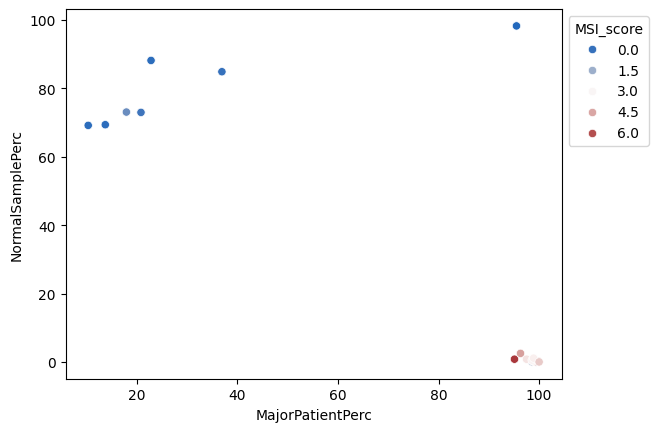

In [17]:
ax = sns.scatterplot(data=l, x='MajorPatientPerc', y='NormalSamplePerc', hue='MSI_score', palette='vlag')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
""" 
Leiden clusters with high MajorPatientPerc means that the cluster is mainly composed of cells from one patient, which is characteristic of tumor clusters.
On the other hand, Leiden clusters with high NormalSamplePerc indicates that they likely represent normal epithelial cells.

Using these two rules, we can assign the tumor/normal status for each Leiden cluster.
""" 

In [18]:
dict_leiden_to_EpiCellType = {
    '0' : 'Normal epithelial',
    '1' : 'Normal epithelial',
    '7' : 'Normal epithelial',
    '8' : 'Normal epithelial',
    '11' : 'Normal epithelial',
    '15' : 'Normal epithelial',
    '16' : 'Normal epithelial',

    '2' : 'Tumor epithelial',
    '3' : 'Tumor epithelial',
    '4' : 'Tumor epithelial',
    '5' : 'Tumor epithelial',
    '6' : 'Tumor epithelial',
    '9' : 'Tumor epithelial',
    '10' : 'Tumor epithelial',
    '12' : 'Tumor epithelial',
    '13' : 'Tumor epithelial',
    '14' : 'Tumor epithelial',
    '17' : 'Tumor epithelial',
}

adata_epi.obs['Manual_CellType_lvl_1'] = [ dict_leiden_to_EpiCellType[leiden] for leiden in adata_epi.obs['leiden'] ]

In [20]:
# Convert MSI score to z-score for better visualization
u, s = np.mean(adata_epi.obs['MSI_score']), np.std(adata_epi.obs['MSI_score'])
adata_epi.obs['MSI_score_z'] = [ (MS-u)/s for MS in adata_epi.obs['MSI_score'] ]

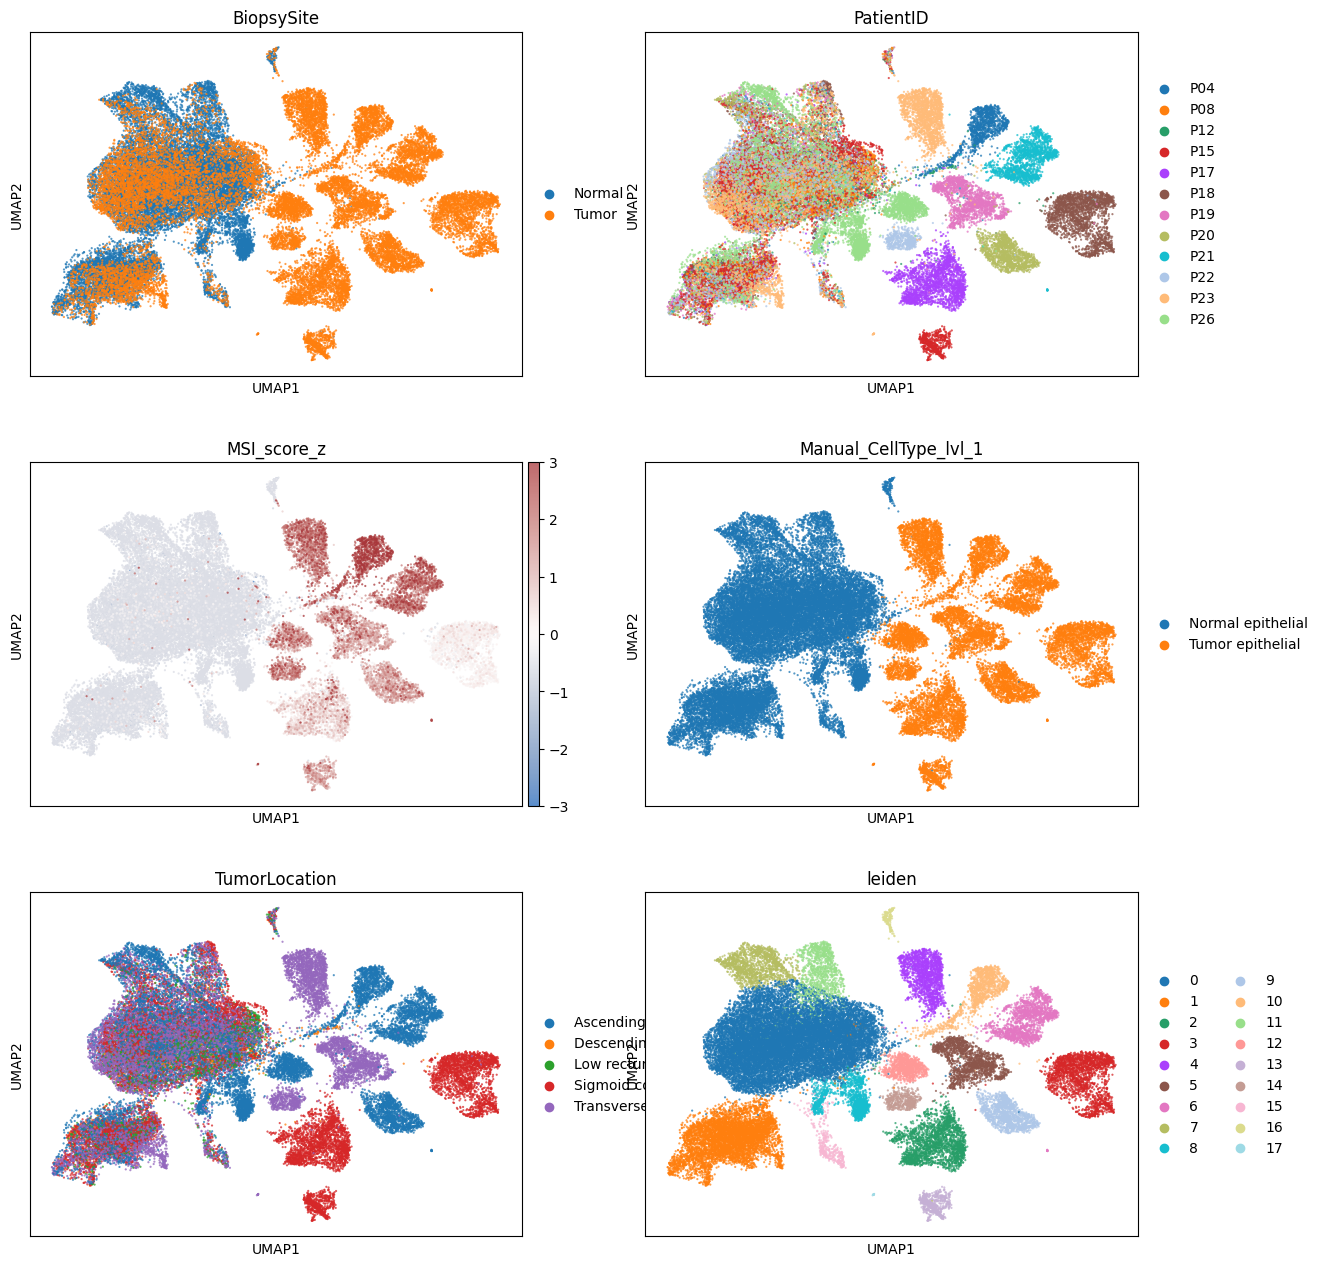

In [21]:
sc.pl.umap(adata_epi, color=['BiopsySite', 'PatientID', 'MSI_score_z', 'Manual_CellType_lvl_1', 'TumorLocation', 'leiden'], ncols=2,
           cmap='vlag', vmin=-3, vmax=3, size=10, alpha=0.75,
)

### No tumor cells for P08 and P12?

In [ ]:
""" 
Strangely, P08 and P12 do not seem to have tumor cells distinctly represented on the UMAP above.
We will re-cluster P08 and P12 cells (separately) to separate normal epithelial cells and tumor cells.
"""

#### P08 → No tumor cells

In [22]:
adata_epi_P08 = adata[(adata.obs['Author_CellType_lvl_1']=='Epi') & (adata.obs['PatientID'].isin(['P08',]))].copy()

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


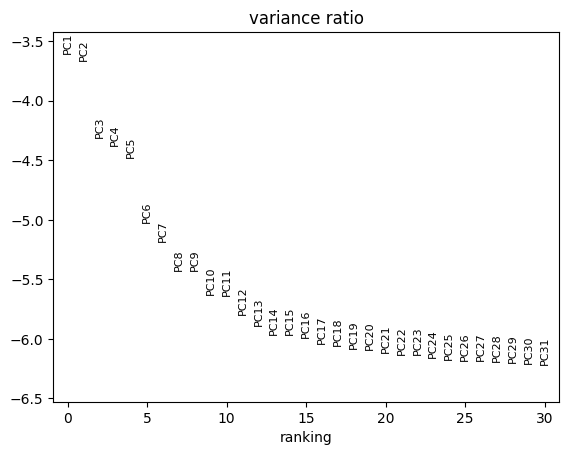

In [23]:
sc.pp.normalize_total(adata_epi_P08)
sc.pp.log1p(adata_epi_P08)
sc.pp.highly_variable_genes(adata_epi_P08, n_top_genes=2000, batch_key="SampleID")
sc.pp.scale(adata_epi_P08, max_value=10)
adata_epi_P08.raw = adata_epi_P08.copy()
adata_epi_P08 = adata_epi_P08[:, adata_epi_P08.var.highly_variable]

sc.tl.pca(adata_epi_P08, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi_P08, log=True)

sc.pp.neighbors(adata_epi_P08, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_P08,)

In [24]:
sc.tl.leiden(adata_epi_P08, resolution=0.2)

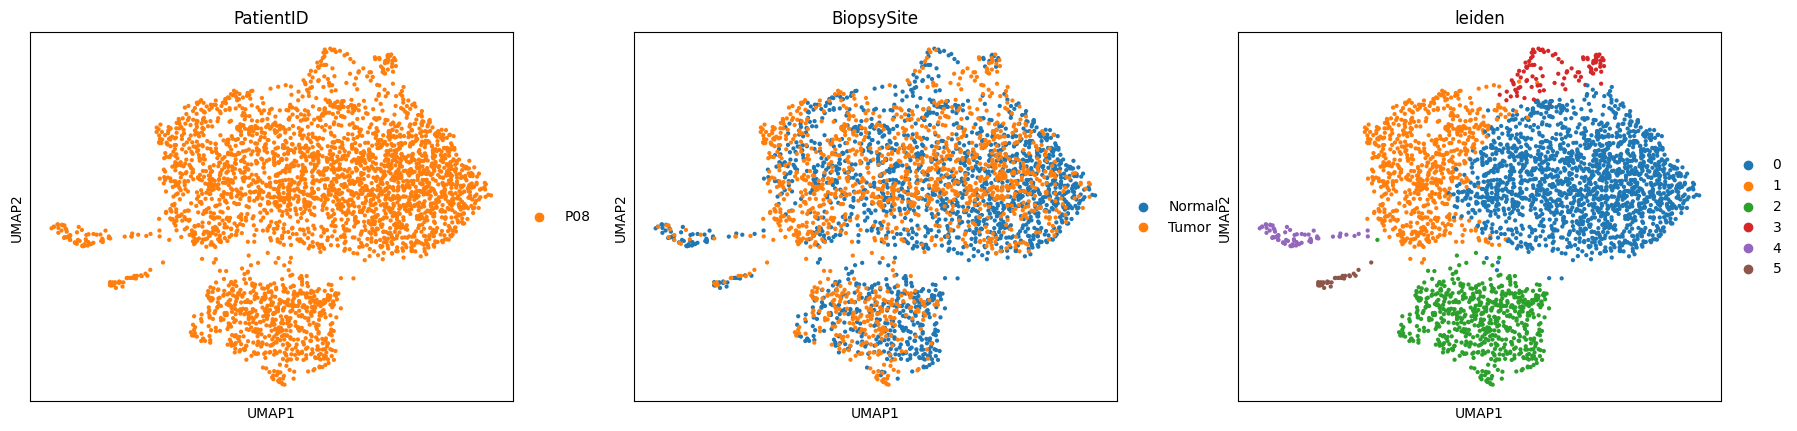

In [25]:
sc.pl.umap(adata_epi_P08, color=['PatientID', 'BiopsySite', 'leiden'])

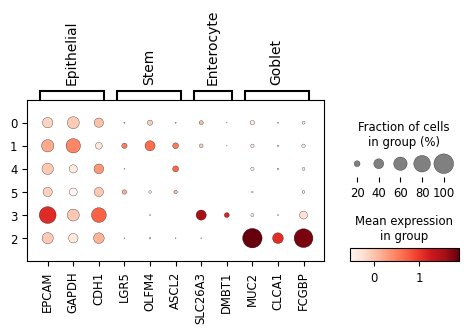

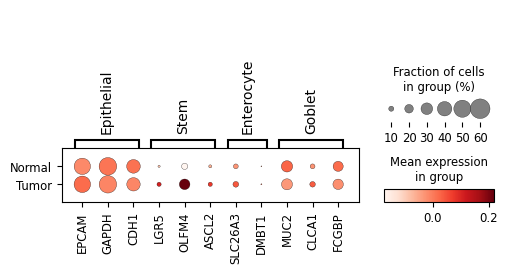

In [26]:
sc.pl.dotplot(adata_epi_P08, var_names={ 'Epithelial' : ['EPCAM', 'GAPDH', 'CDH1',], 
                                           'Stem' : ['LGR5', 'OLFM4', 'ASCL2'],
                                           'Enterocyte' : ['SLC26A3', 'DMBT1', ],
                                           'Goblet' : ['MUC2', 'CLCA1', 'FCGBP', ],
                                           }, groupby='leiden', categories_order=['0', '1', '4', '5', '3', '2'])
sc.pl.dotplot(adata_epi_P08, var_names={ 'Epithelial' : ['EPCAM', 'GAPDH', 'CDH1',], 
                                           'Stem' : ['LGR5', 'OLFM4', 'ASCL2'],
                                           'Enterocyte' : ['SLC26A3', 'DMBT1', ],
                                           'Goblet' : ['MUC2', 'CLCA1', 'FCGBP', ],
                                           }, groupby='BiopsySite',)

In [ ]:
""" 
There is no cluster that seems to represent the tumor cells, and each cluster well represents the epithelial subtypes of the colon epithelium.
We conclude that the dataset does not contain any tumor cells for this patient.
"""

In [28]:
adata_epi_P08.write(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/TumorUnidentified/P08.epi.h5ad')

#### P12 → iCMS2

In [29]:
adata_epi_P12 = adata[(adata.obs['Author_CellType_lvl_1']=='Epi') & (adata.obs['PatientID'].isin(['P12',]))].copy()

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


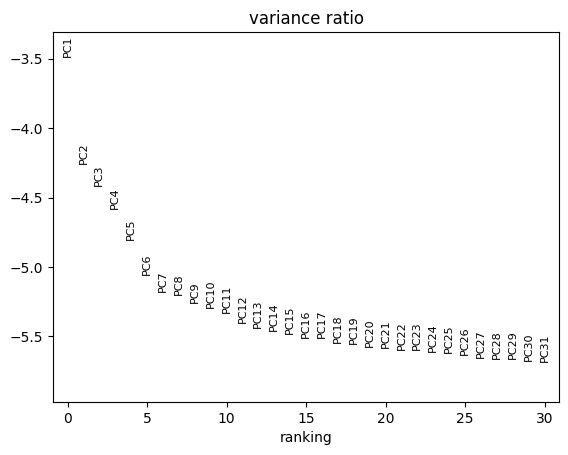

In [30]:
sc.pp.normalize_total(adata_epi_P12)
sc.pp.log1p(adata_epi_P12)
sc.pp.highly_variable_genes(adata_epi_P12, n_top_genes=2000, batch_key="SampleID")
sc.pp.scale(adata_epi_P12, max_value=10)
adata_epi_P12.raw = adata_epi_P12.copy()
adata_epi_P12 = adata_epi_P12[:, adata_epi_P12.var.highly_variable]

sc.tl.pca(adata_epi_P12, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi_P12, log=True)

sc.pp.neighbors(adata_epi_P12, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_P12,)

In [31]:
sc.tl.leiden(adata_epi_P12, resolution=0.2)

In [ ]:
""" 
As shown in the UMAP below, P12 displays a cluster (Leiden cluster 3) that is formed from the tumor sample. 
Let's check if this cluster actually represents MSI CRC.
"""

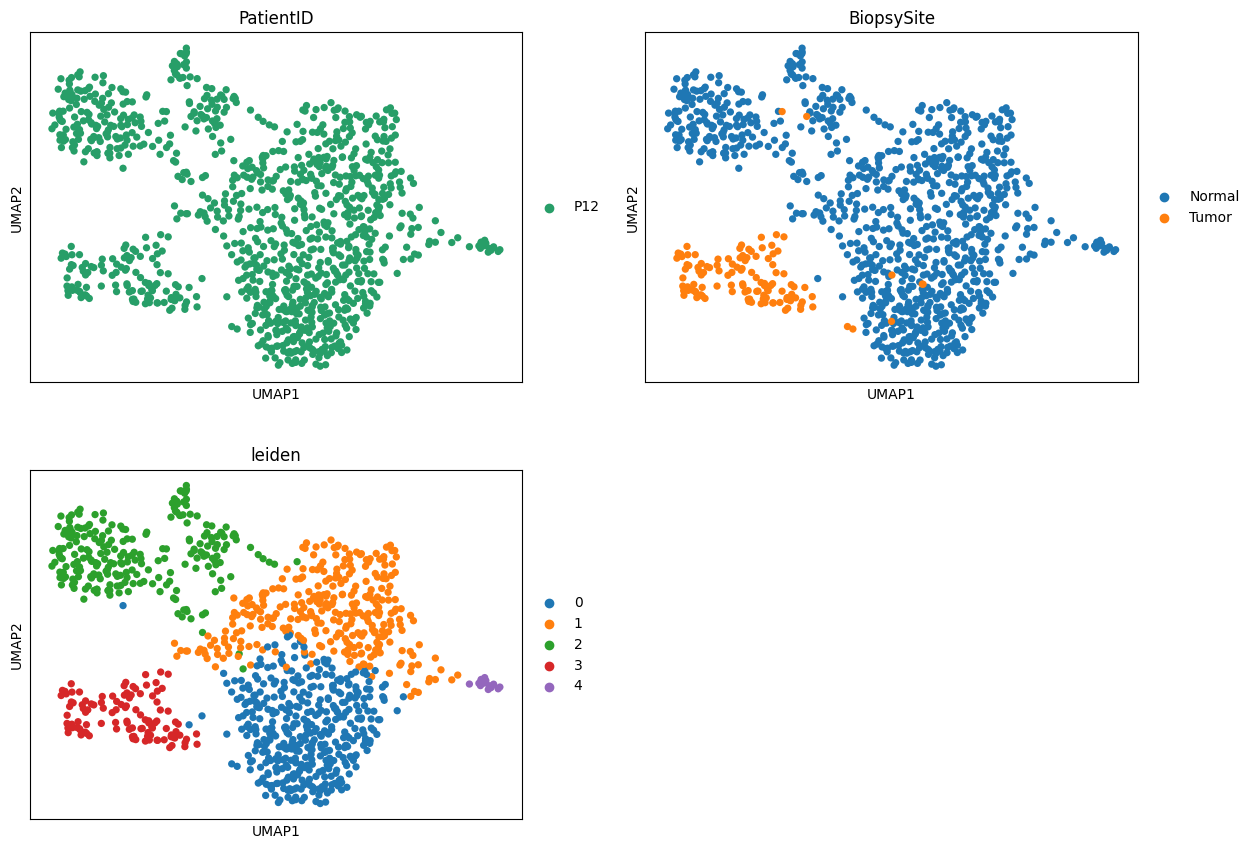

In [32]:
sc.pl.umap(adata_epi_P12, color=['PatientID', 'BiopsySite', 'leiden',], ncols=2, )

In [33]:
sc.tl.score_genes(adata_epi_P12, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata_epi_P12, iCMS3_dw, score_name='iCMS3_dw')
sc.tl.score_genes(adata_epi_P12, iCMS2_up, score_name='iCMS2_up')
sc.tl.score_genes(adata_epi_P12, iCMS2_dw, score_name='iCMS2_dw')

       'C8orf59', 'AC004130.1', 'NUPL2'],
      dtype='object')


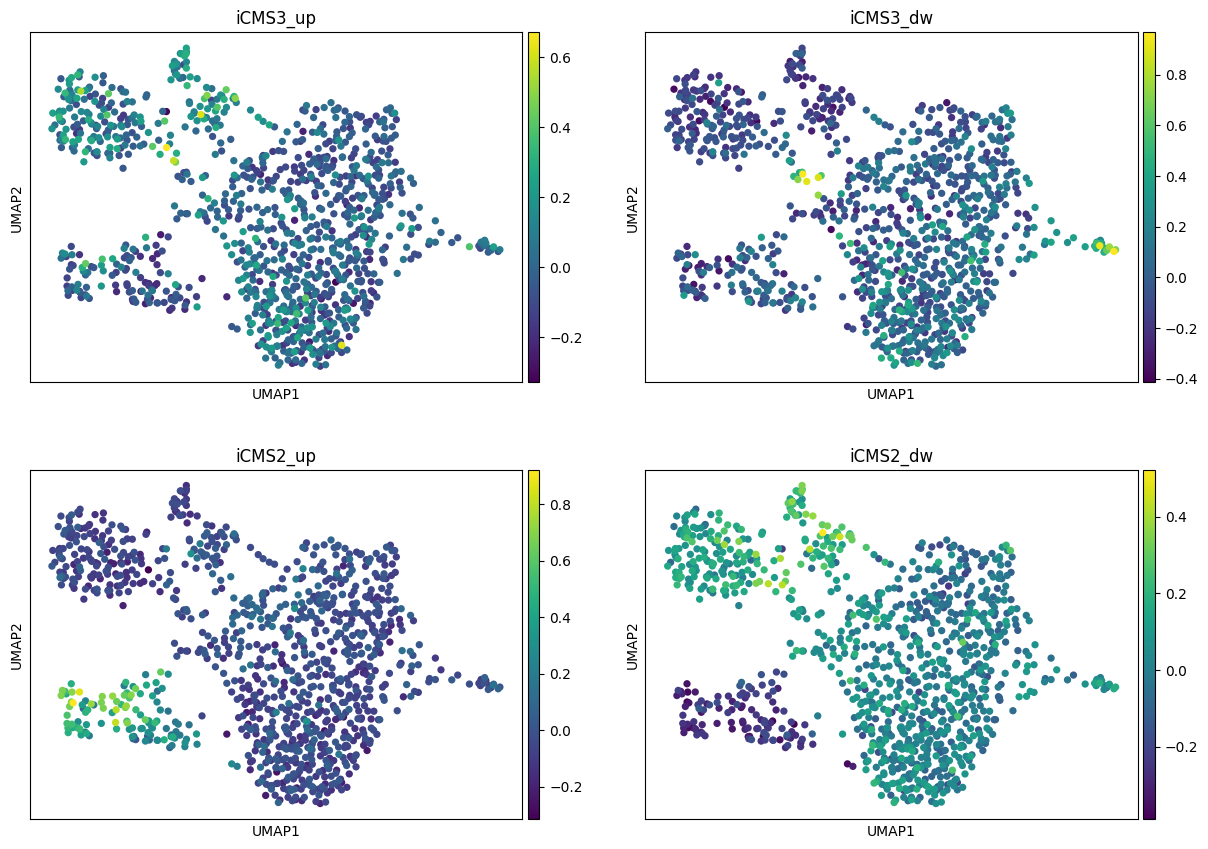

In [34]:
sc.pl.umap(adata_epi_P12, color=['iCMS3_up', 'iCMS3_dw', 'iCMS2_up', 'iCMS2_dw',], ncols=2,)

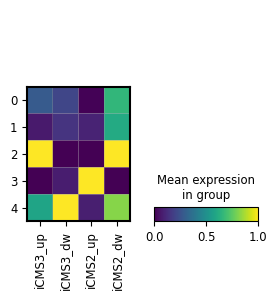

In [35]:
sc.pl.matrixplot(adata_epi_P12,var_names=['iCMS3_up', 'iCMS3_dw', 'iCMS2_up', 'iCMS2_dw', ], groupby='leiden', standard_scale='var',)

In [ ]:
""" 
Strangely, the putative tumor cluster displays high levels of iCMS2-upregulated genes, which is atypical of MSI CRC (Joanito et al).
What's even stranger is that this tumor displays minimal MSI score, as seen below. 
Due to these unusual observations, we exclude P12 from our downstream analyses.
"""

<Axes: xlabel='MSI_score_z', ylabel='leiden'>

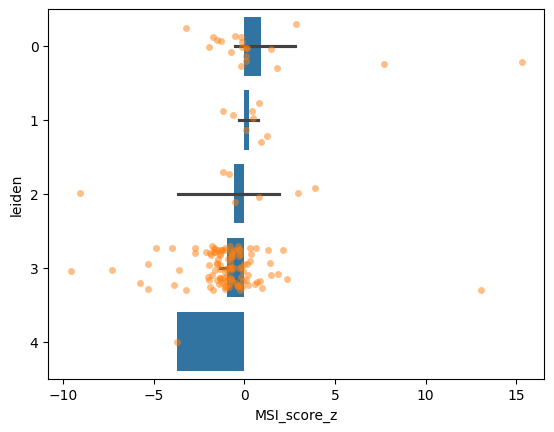

In [36]:
# Convert MSI score to z-score for better visualization
u, s = np.mean(adata_epi_P12.obs['MSI_score']), np.std(adata_epi_P12.obs['MSI_score'])
adata_epi_P12.obs['MSI_score_z'] = [ (MS-u)/s for MS in adata_epi_P12.obs['MSI_score'] ]
sns.barplot(data=adata_epi_P12.obs[(adata_epi_P12.obs['NumSTRLoci']>=2)], y='leiden', x='MSI_score_z', )
sns.stripplot(data=adata_epi_P12.obs[(adata_epi_P12.obs['NumSTRLoci']>=2)], y='leiden', x='MSI_score_z', jitter=0.3, alpha=0.5,)

In [37]:
adata_epi_P12.write(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/TumorUnidentified/P12.epi.h5ad')

### Check iCMS of each patient (all but P12 is iCMS3)

In [38]:
sc.tl.score_genes(adata_epi, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata_epi, iCMS3_dw, score_name='iCMS3_dw')
sc.tl.score_genes(adata_epi, iCMS2_up, score_name='iCMS2_up')
sc.tl.score_genes(adata_epi, iCMS2_dw, score_name='iCMS2_dw')

       'C8orf59', 'AC004130.1', 'NUPL2'],
      dtype='object')


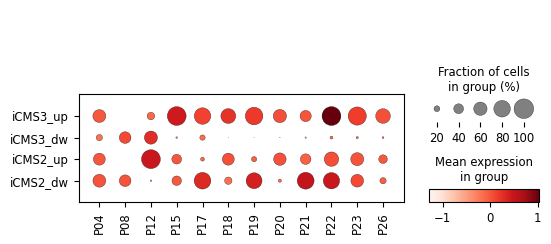

In [39]:
sc.pl.dotplot(adata_epi[adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial'],
              var_names=['iCMS3_up', 'iCMS3_dw', 'iCMS2_up', 'iCMS2_dw', ], groupby='PatientID', swap_axes=True)

In [ ]:
""" 
All patients except P12 displays high iCMS3_up score and low iCMS3_dw score, confirming that these patients represent the typical MSI CRC.
"""

### Label results

In [40]:
# Reload adata because we did adata = adata.raw.to_adata()
adata = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.h5ad')

adata.obs['MSI']        = [ dict_SampleID_to_MSIstatus[SID] for SID in adata.obs['SampleID'] ]
adata.obs['Response']   = [ dict_SampleID_to_Response[SID] for SID in adata.obs['SampleID'] ]
adata = adata[adata.obs['Response']!='SD'].copy()

In [41]:
dict_Identifier_to_ManualCellTypeLvl1 = { tup.Identifier : tup.Manual_CellType_lvl_1 for tup in adata_epi.obs.itertuples() }
for tup in adata.obs.itertuples():
    try:
        dict_Identifier_to_ManualCellTypeLvl1[tup.Identifier]
    except KeyError:
        dict_Identifier_to_ManualCellTypeLvl1[tup.Identifier] = 'N/A'

adata.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_ManualCellTypeLvl1[identifier] for identifier in adata.obs['Identifier'] ]

In [16]:
adata[~(adata.obs['PatientID'].isin(['P08', 'P12']))].write(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')
adata_epi[~(adata_epi.obs['PatientID'].isin(['P08', 'P12']))].write(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

In [43]:
adata.write(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/AllPatients/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')
adata_epi.write(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/AllPatients/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

## Joanito et al

In [ ]:
""" 
We repeat this process for this dataset.
"""

In [44]:
joanito_metadata = pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/patient_clinical_information.csv', encoding = "ISO-8859-1")
joanito_metadata = joanito_metadata[joanito_metadata['dataset'].isin(['CRC-SG1', 'KUL5', 'KUL3'])].copy()

dict_PatientID_to_MSIstatus  = { list(tup)[2] : tup.MSS_MSI for tup in joanito_metadata.itertuples() }

In [45]:
adata = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.h5ad')
adata = adata.raw.to_adata()
adata.obs = -1  * adata.obs['AvgSTRDiff'] * adata.obs['StdSTRDiff']

In [46]:
adata.obs['MSI'] = [ dict_PatientID_to_MSIstatus[PatientID] for PatientID in adata.obs['PatientID'] ]

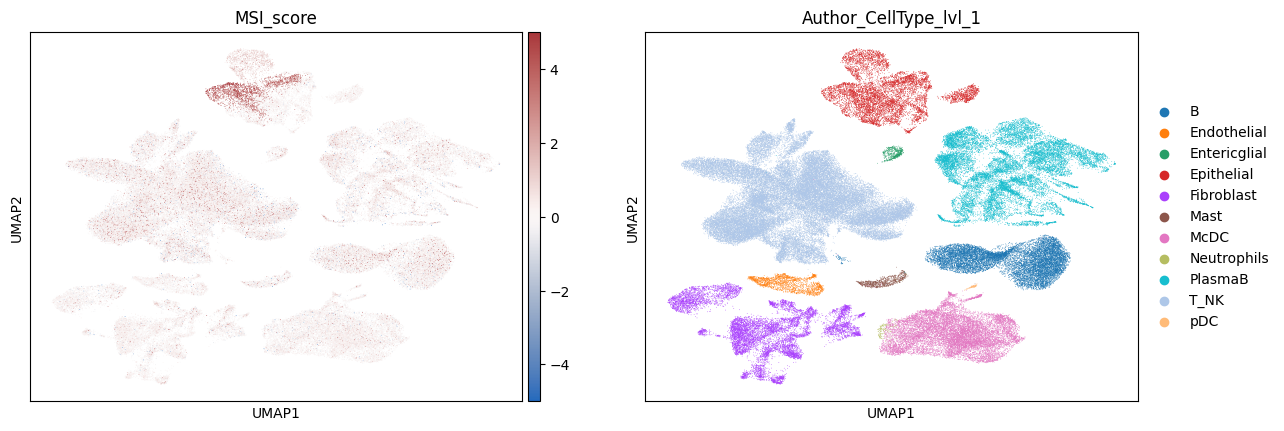

In [54]:
sc.pl.umap(adata, color=['MSI_score', 'Author_CellType_lvl_1', ], vmin=-5, vmax=5, cmap='vlag')

### Epithelial subclustering - Distinguishing Tumor vs. Normal epithelial

In [55]:
adata_epi = adata[(adata.obs['Author_CellType_lvl_1']=='Epithelial')].copy()

In [56]:
onlySingleCellSample = list()
for SampleID, edf in adata_epi.obs.groupby("SampleID"):
    if len(edf) <= 1:
        print(SampleID)
        onlySingleCellSample.append(SampleID)
adata_epi = adata_epi[~(adata_epi.obs['SampleID'].isin(onlySingleCellSample))].copy()

/tmp/ipykernel_41323/2165763383.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_epi.obs.groupby("SampleID"):


XHC166


In [57]:
adata_epi.raw = adata_epi.copy()
sc.pp.normalize_total(adata_epi)
sc.pp.log1p(adata_epi)
sc.pp.highly_variable_genes(adata_epi, n_top_genes=2000, batch_key="SampleID")
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


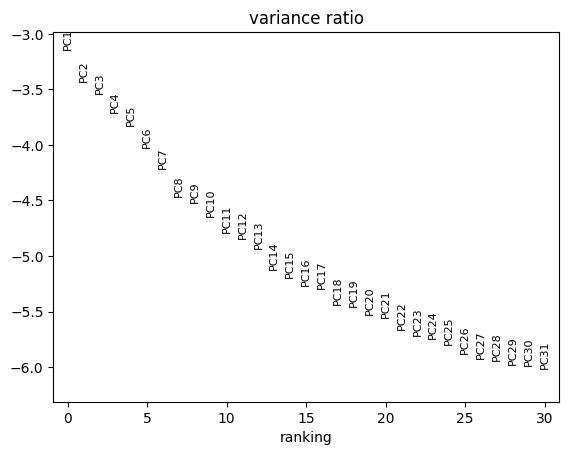

In [58]:
sc.pp.scale(adata_epi, max_value=10)
sc.tl.pca(adata_epi, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi, log=True)

In [59]:
sc.pp.neighbors(adata_epi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi,)

In [60]:
sc.tl.leiden(adata_epi, resolution=0.15)

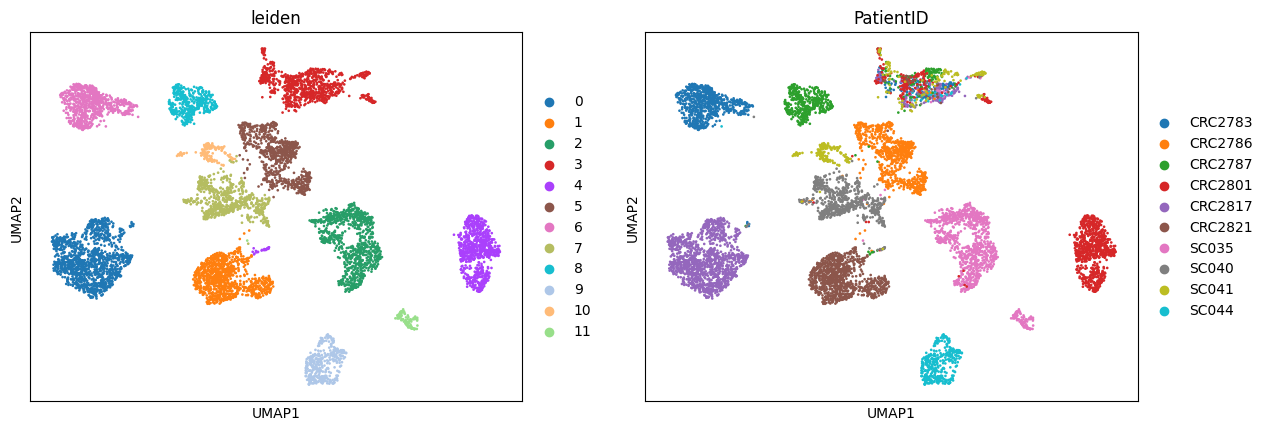

In [61]:
sc.pl.umap(adata_epi, color=['leiden', 'PatientID'])

In [62]:
""" 
Although Core/Invasive/Lymphnode each denote different sections of the tumor and its metastasis locations, 
we collapse these into one category: tumor, to indicate that these samples may contain tumor cells.
""" 
dict_BiopsySite_to_BiopsySite2 = {
    'Adjacent normal tissue' : 'Normal',
    'Core' : 'Tumor',
    'Invasive' : 'Tumor',
    'LymphNode' : 'Tumor',
    'Normal' : 'Normal',
    'Tumor' : 'Tumor'
}

adata_epi.obs['BiopsySite2'] = [ dict_BiopsySite_to_BiopsySite2[BS] for BS in adata_epi.obs['BiopsySite'] ]

In [67]:
# Inspect patient-heterogeneity of each patient
l = list()

for leiden, edf in adata_epi.obs.groupby('leiden'):
    dict_PatientID_to_proportion = dict()
    for PatientID, edf2 in edf.groupby('PatientID'):
        dict_PatientID_to_proportion[PatientID] = len(edf2)/len(edf)
    dict_PatientID_to_proportion = dict(sorted(dict_PatientID_to_proportion.items(), key=lambda x:x[1], reverse=True))
    
    for PatientID, proportion in dict_PatientID_to_proportion.items():
        MajorPatientID = PatientID
        MajorProportion1 = proportion
        break 
    
    dict_BiopsySite_to_proportion = dict()
    for BiopsySite, edf2 in edf.groupby('BiopsySite2'):
        dict_BiopsySite_to_proportion[BiopsySite] = len(edf2)/len(edf)
    
    if 'Normal' not in dict_BiopsySite_to_proportion.keys():
        dict_BiopsySite_to_proportion['Normal'] = 0
    
    
    print(f'{leiden}\t\t{round(100*MajorProportion1, 1)}\t\t\t{round(100*dict_BiopsySite_to_proportion['Normal'], 1)}\t\t{round(np.mean(edf[edf['NumSTRLoci']!=0]['MSI_score']), 1)}')
    l.append( [leiden, round(100*MajorProportion1, 1), round(100*dict_BiopsySite_to_proportion['Normal'], 1), round(np.mean(edf[edf['NumSTRLoci']!=0]['MSI_score']), 1)] )

l = pd.DataFrame(l, columns=['leiden', 'MajorPatientPerc', 'NormalSamplePerc', 'MSI_score'])

0		99.3			0.4		0.9
1		99.7			0		0.1
2		99.6			0		3.9
3		20.1			70.4		0.1
4		97.2			1.2		0.1
5		99.1			1.4		0.1
6		99.7			0		3.5
7		96.5			51.2		-0.1
8		100.0			0		0.1
9		100.0			0		7.6
10		100.0			0		-0.2
11		100.0			0		5.5


/tmp/ipykernel_41323/798989150.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for leiden, edf in adata_epi.obs.groupby('leiden'):
/tmp/ipykernel_41323/798989150.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf2 in edf.groupby('PatientID'):
/tmp/ipykernel_41323/798989150.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf2 in edf.groupby('PatientID'):
/tmp/ipykernel_41323/7989

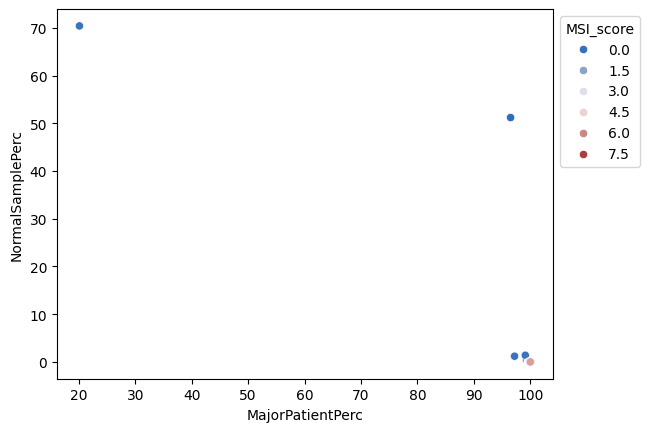

In [68]:
ax = sns.scatterplot(data=l, x='MajorPatientPerc', y='NormalSamplePerc', hue='MSI_score', palette='vlag')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [70]:
dict_leiden_to_EpiCellType = {
    '3' : 'Normal epithelial',

    '0' : 'Tumor epithelial',
    '1' : 'Tumor epithelial',
    '2' : 'Tumor epithelial',
    '4' : 'Tumor epithelial',
    '5' : 'Tumor epithelial',
    '6' : 'Tumor epithelial',
    '8' : 'Tumor epithelial',
    '9' : 'Tumor epithelial',
    '10' : 'Tumor epithelial',
    '11' : 'Tumor epithelial',
    '7' : 'Tumor epithelial', #! Mixed with NAT

}

adata_epi.obs['Manual_CellType_lvl_1'] = [ dict_leiden_to_EpiCellType[leiden] for leiden in adata_epi.obs['leiden'] ]

In [71]:
# Convert MSI score to z-score for better visualization
u, s = np.mean(adata_epi.obs['MSI_score']), np.std(adata_epi.obs['MSI_score'])
adata_epi.obs['MSI_score_z'] = [ (MS-u)/s for MS in adata_epi.obs['MSI_score'] ]

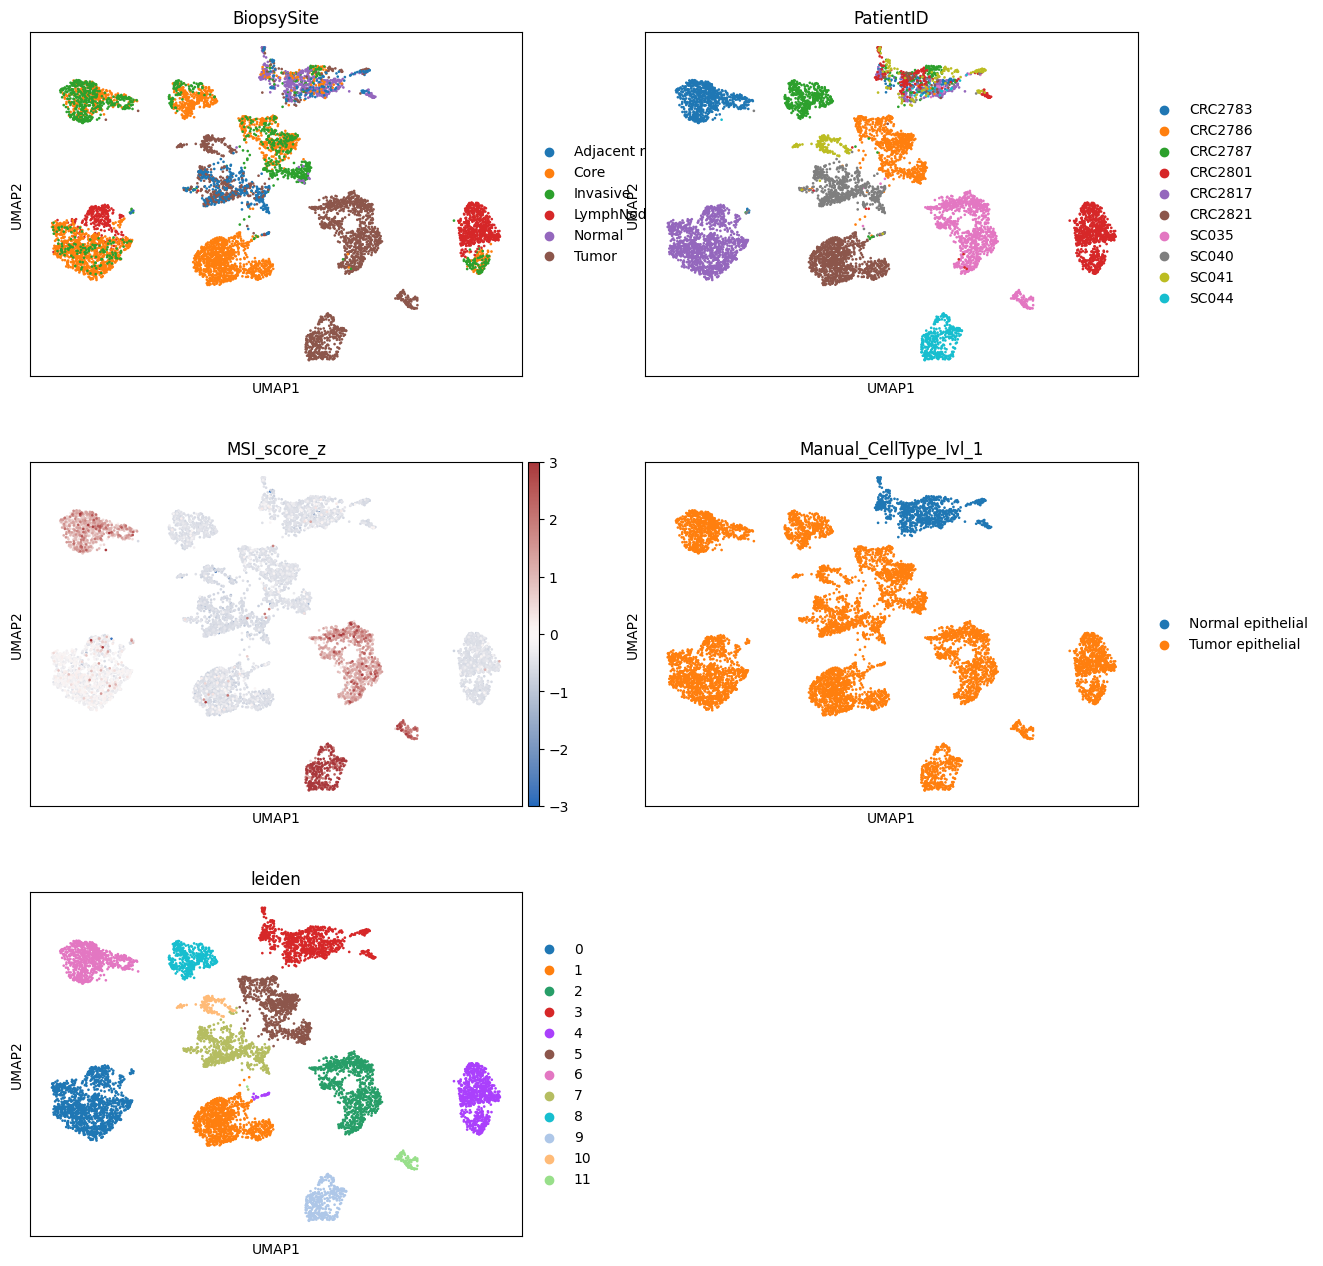

In [151]:
sc.pl.umap(adata_epi, color=['BiopsySite', 'PatientID', 'MSI_score_z', 'Manual_CellType_lvl_1', 'leiden'], ncols=2,
           cmap='vlag', vmin=-3, vmax=3,
)

In [152]:
adata_epi.write(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

In [153]:
# Reload adata because we did adata = adata.raw.to_adata()
adata = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.h5ad')

adata.obs['MSI'] = [ dict_PatientID_to_MSIstatus[PatientID] for PatientID in adata.obs['PatientID'] ]

In [155]:
dict_Identifier_to_ManualCellTypeLvl1 = { tup.Identifier : tup.Manual_CellType_lvl_1 for tup in adata_epi.obs.itertuples() }
for tup in adata.obs.itertuples():
    try:
        dict_Identifier_to_ManualCellTypeLvl1[tup.Identifier]
    except KeyError:
        dict_Identifier_to_ManualCellTypeLvl1[tup.Identifier] = 'N/A'

adata.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_ManualCellTypeLvl1[identifier] for identifier in adata.obs['Identifier'] ]

In [156]:
adata.write(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')

### Figure

In [157]:
adata = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [158]:
adata_epi = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

In [159]:
# Convert MSI score to z-score for better visualization
u, s = np.mean(adata.obs['MSI_score']), np.std(adata.obs['MSI_score'])
adata.obs['MSI_score_z'] = [ (MS-u)/s for MS in adata.obs['MSI_score'] ]

u, s = np.mean(adata_epi.obs['MSI_score']), np.std(adata_epi.obs['MSI_score'])
adata_epi.obs['MSI_score_z'] = [ (MS-u)/s for MS in adata_epi.obs['MSI_score'] ]

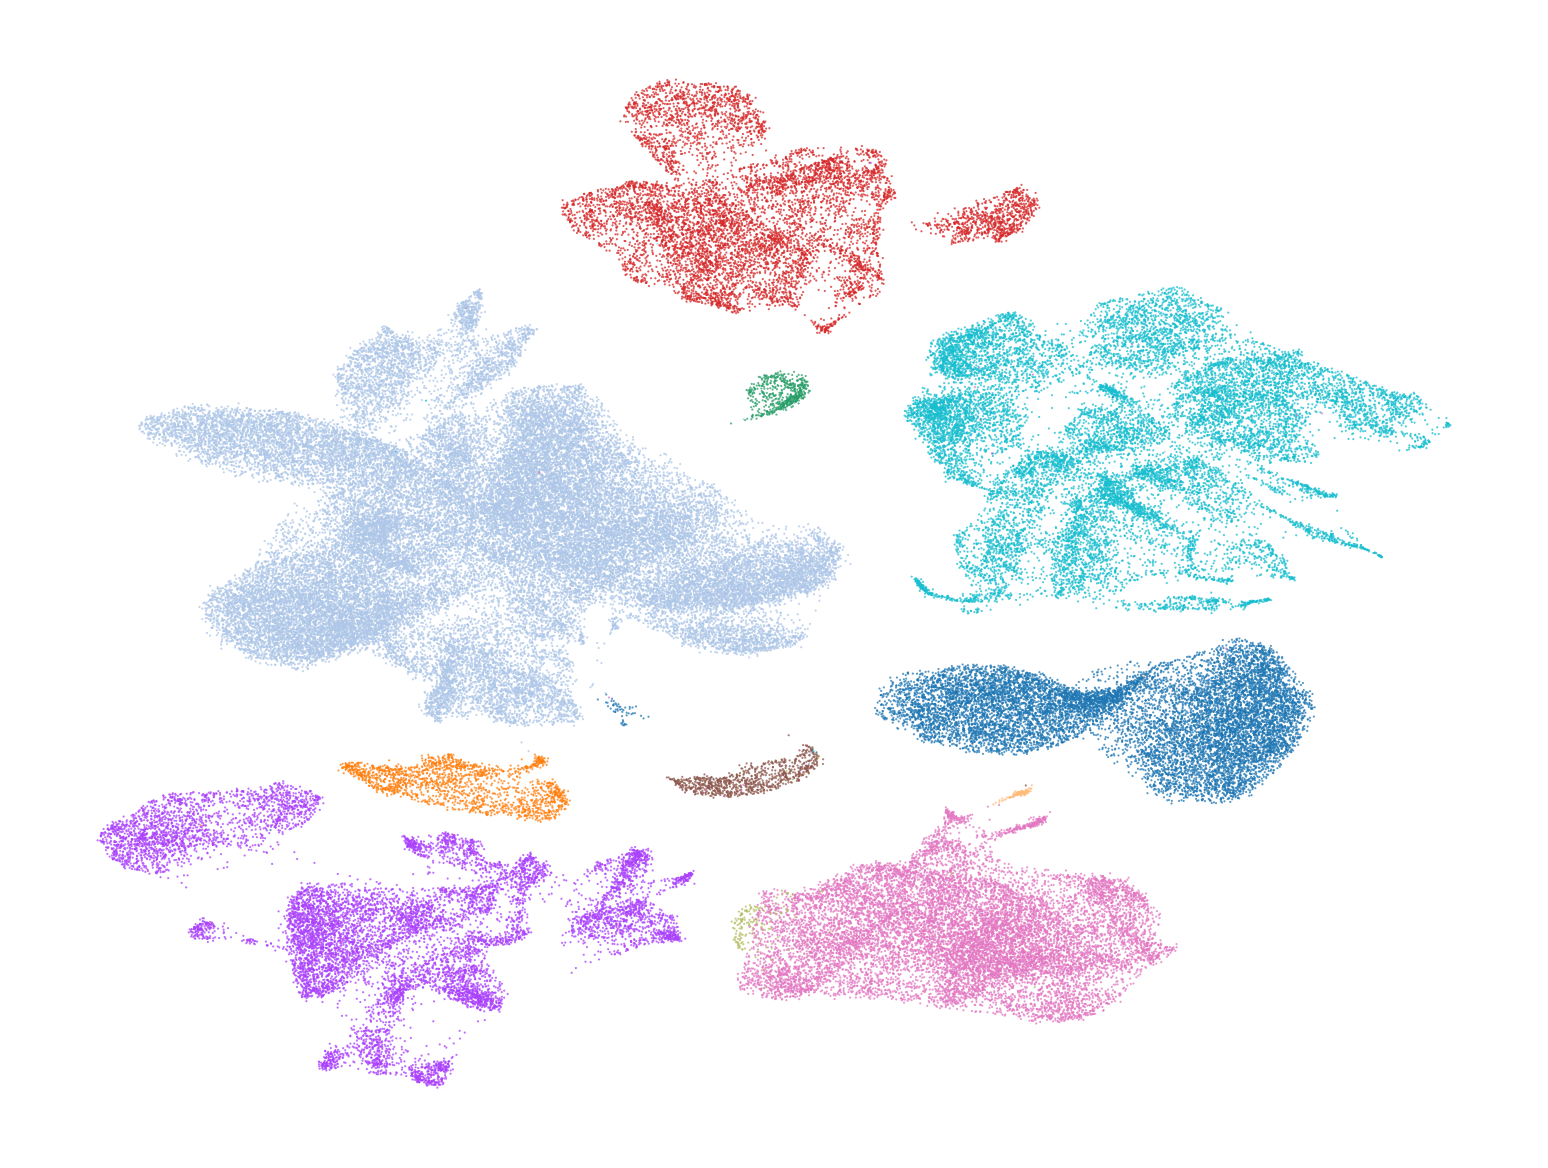

In [160]:
with plt.rc_context({"figure.dpi": (300)}):
    sc.pl.umap(adata, color=['Author_CellType_lvl_1'], alpha=0.75, frameon=False, legend_loc=None, title='',)

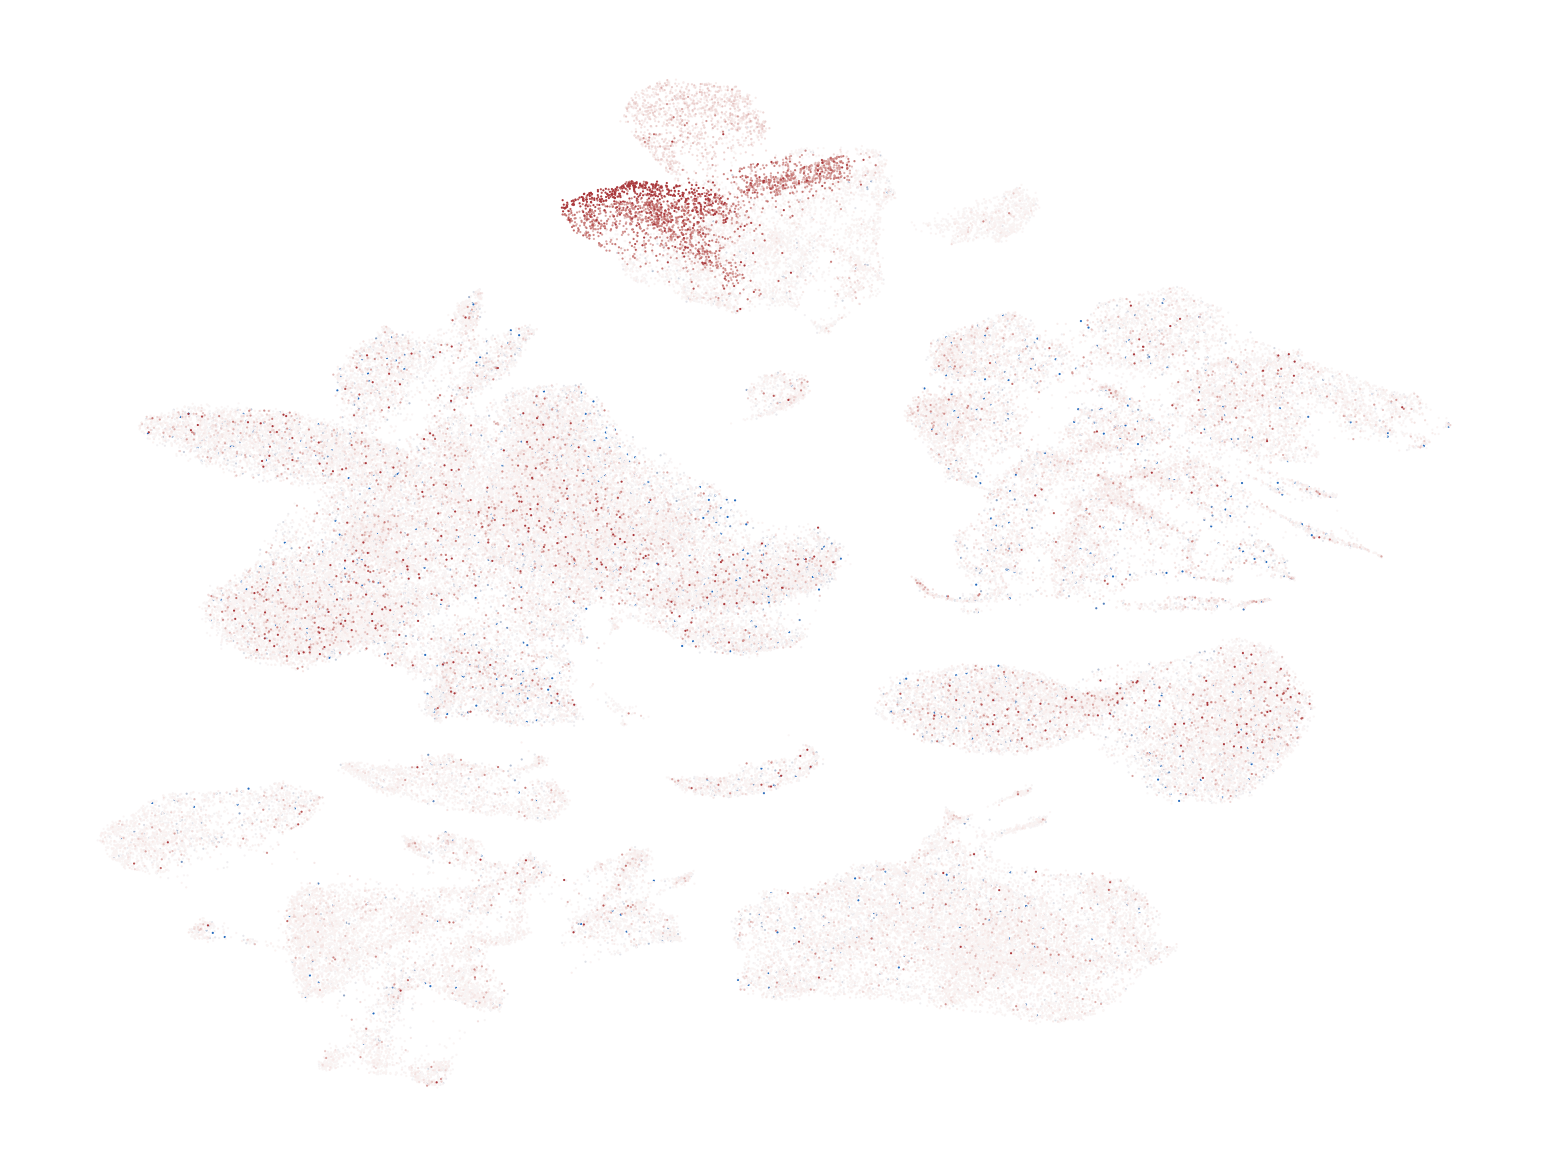

In [163]:
with plt.rc_context({"figure.dpi": (300)}):
    sc.pl.umap(adata, color=['MSI_score_z'],
               vmin=-2, vmax=2, cmap='vlag', alpha=1, frameon=False, colorbar_loc=None, title='')

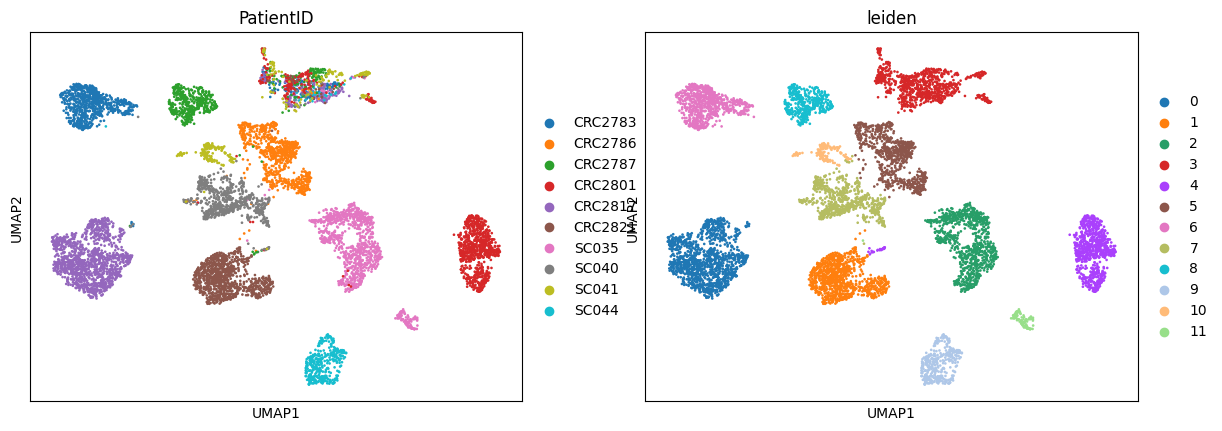

In [6]:
sc.pl.umap(adata_epi, color=['PatientID', 'leiden'])

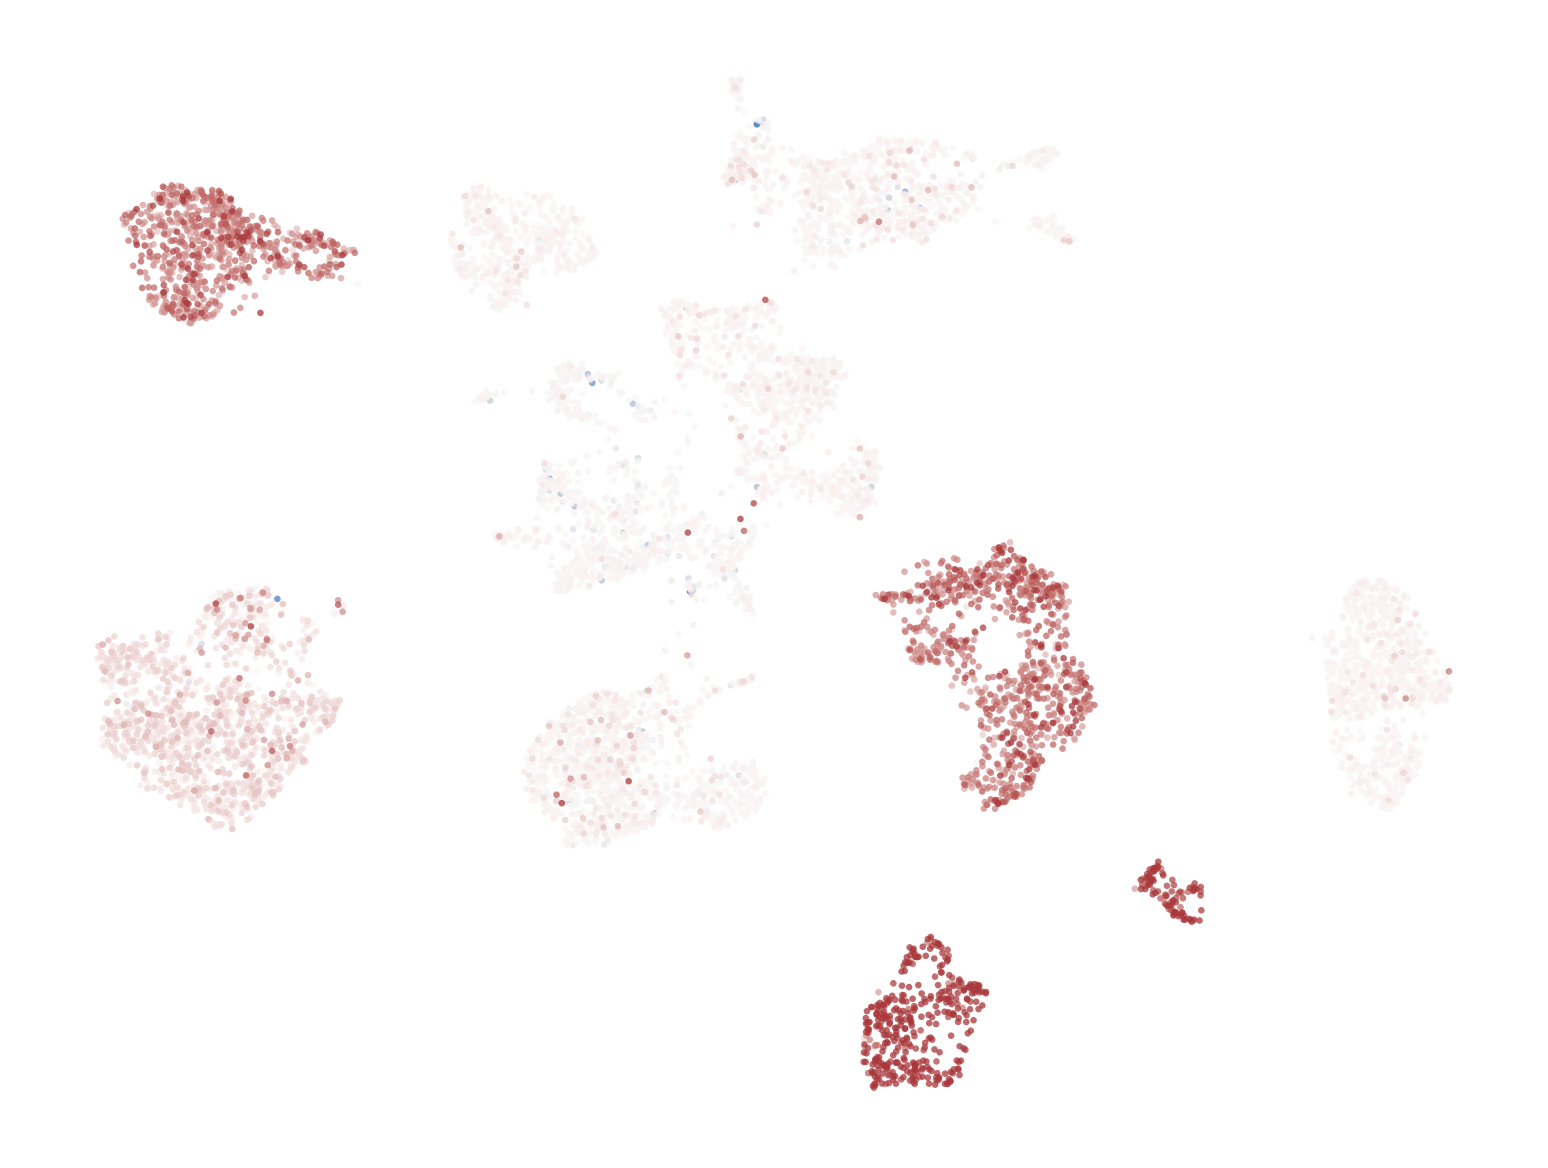

In [166]:
with plt.rc_context({"figure.dpi": (300)}):
    sc.pl.umap(adata_epi, color=['MSI_score'],
               vmin=-6, vmax=6, cmap='vlag', s=10, alpha=0.75, frameon=False, colorbar_loc=None, title='')